## FischSchwarm mit Turtle Grafik

### Aufgaben - Tasks

- Lesen Sie den folgenden Quellcode
- Lassen Sie das Programm mehrmals laufen
- Vergrössern Sie die Anzahl Zeitschritte
- Ändern Sie die Parameter der Schwarmeingenschaften


In [5]:
from turtle import Turtle, Screen
import random
from math import cos, radians


class Schooler(Turtle):
    swarm = []

    def __init__(self):
        Turtle.__init__(self)
        self.up()
        self.setheading(random.randrange(360))
        self.setpos(random.randrange(-200,200),random.randrange(-200,200))
        self.down()
        self.newHead = None
        Schooler.swarm.append(self)

    def getNewHeading(self):
        minangle = 999
        for other in Schooler.swarm:
            if self != other:
                head = self.towards(other) - self.heading()
                if cos(radians(head)) > 0:
                    if head < minangle:
                        minangle = head
        if minangle == 999:
            self.newHead = self.heading()
        else:
            self.newHead = minangle+self.heading()

    def inFrontOf(self,other):
        head = self.towards(other) - self.heading()
        if cos(radians(head)) > 0:
            return True
        return False

    def setHeadingAndMove(self):
        self.setheading(self.newHead)
        self.newHead = None
        self.forward(10)

class FocalFish(Schooler):
    # Schwarmeigenschaften
    repulse = 100
    align = 20
    attract = 200

    def getNewHeading(self):
        repulsion = []
        alignment = []
        attraction = []

        for other in Schooler.swarm:
            if self != other:
                dist = self.distance(other)
                if dist <= self.repulse:
                    repulsion.append(other)
                elif dist <= self.align:
                    alignment.append(other)
                elif dist <= self.attract:
                    attraction.append(other)

        self.newHead = self.heading()
        if repulsion:
            x = 0
            y = 0
            for o in repulsion:
                x = x + o.xcor()
                y = y + o.ycor()

            self.newHead = self.towards(x/len(repulsion),y/len(repulsion)) + 180

        elif alignment:
            hs = self.heading()
            for other in alignment:
                hs = hs + other.heading()
            self.newHead = hs // (len(alignment)+1)

        elif attraction:
            x = 0
            y = 0
            for o in attraction:
                x = x + o.xcor()
                y = y + o.ycor()
            self.newHead = self.towards(x/len(attraction),y/len(attraction))




def main():
    swarmSize = 50
    t = Turtle()
    win = Screen()
    win.setworldcoordinates(-600,-600,600,600)
    t.speed(10)
    t.hideturtle()
    t.tracer(15)

    
    # Schwarm erzeugen
    for i in range(swarmSize):
        FocalFish()

    #Anzahl Zeitschritte    
    for turn in range(50):
        
        # Richtung jedes Tiers bestimmen
        for schooler in Schooler.swarm:
            schooler.getNewHeading()

        # Bewegung ausführen    
        for schooler in Schooler.swarm:
            schooler.setHeadingAndMove()
    
    win.exitonclick()

main()


## Vogelschwarm

### Darstellung zu diskreten Zeitschritten

Einfacher Schwarm ohne Jäger

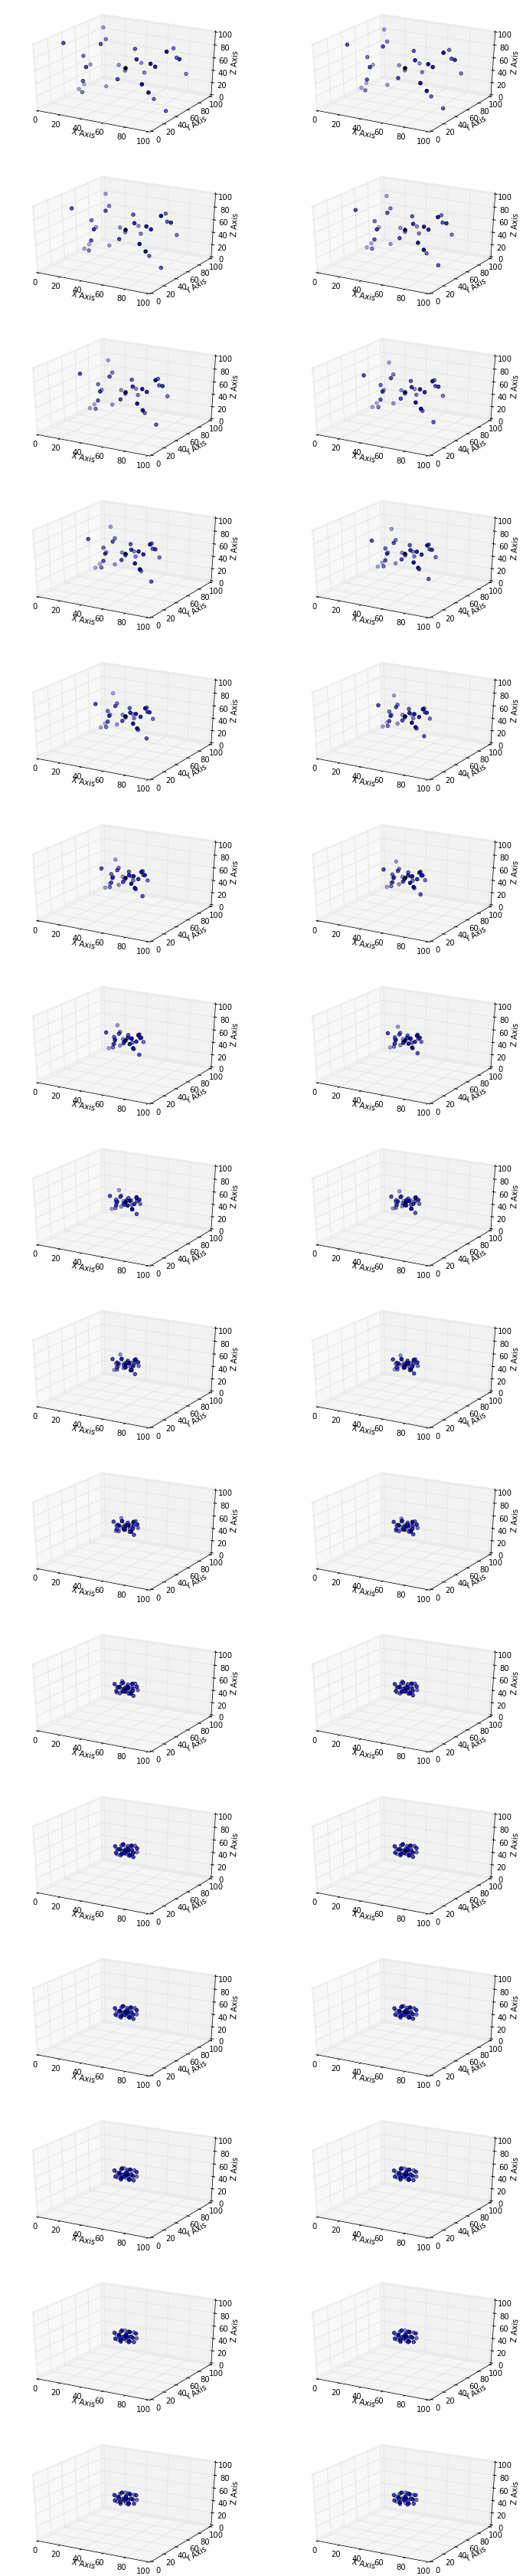

In [38]:
import numpy
import time
import sys
import math
 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
 
 
#################
# Runtime parameters
NumberOfBoids       = 30
Dimensions          = 3
MinSeparation       = 7

 
 
# Boids behavior - weight on rules
WeightCenterOfMass  = 0.03
WeightSeparation    = 1
WeightAlignment     = 0.125
WeightRandom        = 0.0
WeightAvoidPredator = 1
WeightCenter        = 0.02 #0.03
 
MaxVelocityP        = 1
MaxVelocity         = 1
center              = 50*numpy.ones(Dimensions)
###########
 
class boid:
    """This class defines the boid and the rules of behavoir"""
    def __init__(self, dimension, index):
        self.index  = index
        self.dim    = dimension
        self.pos    = numpy.random.uniform(0,100,self.dim)
        self.vel    = numpy.zeros(self.dim)
        self.size   = numpy.random.rand(1)
 
    def limitvelocity(self,maxvel):
        """Limiting the speed to avoid unphysical jerks in motion"""
        if numpy.linalg.norm(self.vel) > maxvel:
            self.vel = (self.vel/numpy.linalg.norm(self.vel))*maxvel

def normalize(vector):
    """Normalizes a vector"""
    vector = vector/numpy.linalg.norm(vector)
    return vector
 
def centerofpos(flock):
    """Calculates the 'center of mass' for the flock of boids"""
    com = numpy.zeros(Dimensions)   
    for dim in range(Dimensions):
        for boid in flock:
            com[dim] = com[dim] + boid.pos[dim]
        com[dim] = com[dim]/len(flock)
    return com
 
def centerofvel(flock):
    """Calculates the mean velocity vector for the flock of boids"""
    cov = numpy.zeros(Dimensions)   
    for dim in range(Dimensions):
        for boid in flock:
            cov[dim] = cov[dim] + boid.vel[dim]
        cov[dim] = cov[dim]/len(flock)
    return cov
 
def plot_raw(a,b,c):
    """Sets up the basic plotting paramaters"""
    global ax
    ax = fig.add_subplot(a,b,c, projection='3d')
    ax.set_autoscale_on(False)
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.set_xlim3d([0.0, 100.0])
    ax.set_ylim3d([0.0, 100.0])
    ax.set_zlim3d([0.0, 100.0])

def plot_init():
    """The initial draw"""
    #plot_raw(221)
    com = centerofpos(flock)
    boidpos = numpy.zeros((NumberOfBoids, Dimensions))
    #predpos = numpy.zeros((NumberOfPredators, Dimensions))
 
    for index,boid in enumerate(flock):
        boidpos[index]= boid.pos       
    bx = boidpos[:,0]
    by = boidpos[:,1]
    bz = boidpos[:,2] 

def plot_update(timestep):
    """ This plot updates the plot with the new positions of the boids
    and predators"""
 
    # 4 Zeitschritte berechnen
    for i in range(4):
        mainloop(timestep)
 
    # Plots the boids in space using matplotlib
    # http://matplotlib.org/examples/mplot3d/scatter3d_demo.html         
    boidpos = numpy.zeros((NumberOfBoids, Dimensions))
    #predpos = numpy.zeros((NumberOfPredators, Dimensions))
 
    # Plot center of mass as a black dot
    com = centerofpos(flock)
    ax.scatter(com[0], com[1], com[2], color='black')
 
    # Plot boids as blue dots     
    for index,boid in enumerate(flock):
        boidpos[index]= boid.pos       
    bx = boidpos[:,0]
    by = boidpos[:,1]
    bz = boidpos[:,2] 
    ax.scatter(bx, by, bz, c='b')
   
 
def mainloop(timestep):
    """This is the calculation timeloop"""
    #print "Timestep "+str(timestep)
 
    for boid in flock:
 
        # Boid RULE 1. Cohesion - Steer to move towoards the center of mass
        rule1 = numpy.zeros(Dimensions)
        rule1 = (centerofpos(flock) - boid.pos)*WeightCenterOfMass
 
        # Boid RULE RULE 2. Separation - steer to avoid crowding local flockmates
        rule2 = numpy.zeros(Dimensions)
        for boid2 in flock:
            difference  = boid2.pos - boid.pos
            distance    = numpy.linalg.norm(difference)
            if distance < MinSeparation and boid2 != boid:
                rule2 = rule2 - normalize(difference)/distance
        rule2 = rule2*WeightSeparation 
 
        # Boid RULE 3. Alignment - Steer towards the average heading of local flockmates
        rule3 = numpy.zeros(Dimensions)
        rule3 = (centerofvel(flock) - boid.vel)*WeightAlignment
 
 
        # The following rules are custom rules just added for fun. 
        # Boid RULE 4. Try to move towards the center of the grid
        #rule4 = (center - boid.pos)*WeightCenter
 
        # Boid RULE 5. Add some randomness
        #rule5 = numpy.random.uniform(-1,1,Dimensions)*WeightRandom
 

        # Move the boids
        boid.vel = rule1 + rule2 + rule3 #+ rule4 + rule5 + rule6
        boid.limitvelocity(MaxVelocity)
        boid.pos = boid.pos + boid.vel
        
 
#Generate the the flock of boids
flock           = [boid(Dimensions,count) for count in range(NumberOfBoids)]
 

 
# Define the figure:
fig = plt.figure(figsize=(12,60))

# Anzahl Plots
n = 16

for i in range(n):
    plot_raw(n,2,i*2+1)
    plot_update(i)
    
    plot_raw(n,2,(i+1)*2)
    plot_update(i)
 

### Animation erstellen

In [6]:
### use: FFMPEG with WEBM V8 Codec from libvpx 
%pylab inline

# WEBM Chrome Linux MACOSX
from tempfile import NamedTemporaryFile
from IPython.display import HTML

VIDEO_TAG = """<video controls>
 <source src="data:video/webm;base64,{0}" type="video/webm">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.webm') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libvpx'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)



def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [5]:
import numpy
import time
import sys
import math
 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
 
 
#################
# Runtime parameters
NumberOfBoids       = 45
Dimensions          = 3
MinSeparation       = 7
framespersecond     = 10
timesteps           = 40 #Should be divisible by framespersecond
 
 
# Boids behavior - weight on rules
WeightCenterOfMass  = 0.03
WeightSeparation    = 1
WeightAlignment     = 0.125
WeightRandom        = 0.0
WeightAvoidPredator = 1
WeightCenter        = 0.02 #0.03
 
MaxVelocityP        = 1
MaxVelocity         = 1
center              = 10*numpy.ones(Dimensions)
###########
 
class boid:
    """This class defines the boid and the rules of behavoir"""
    def __init__(self, dimension, index):
        self.index  = index
        self.dim    = dimension
        self.pos    = numpy.random.uniform(0,100,self.dim)
        self.vel    = numpy.zeros(self.dim)
        self.size   = numpy.random.rand(1)
 
    def limitvelocity(self,maxvel):
        """Limiting the speed to avoid unphysical jerks in motion"""
        if numpy.linalg.norm(self.vel) > maxvel:
            self.vel = (self.vel/numpy.linalg.norm(self.vel))*maxvel

def normalize(vector):
    """Normalizes a vector"""
    vector = vector/numpy.linalg.norm(vector)
    return vector
 
def centerofpos(flock):
    """Calculates the 'center of mass' for the flock of boids"""
    com = numpy.zeros(Dimensions)   
    for dim in range(Dimensions):
        for boid in flock:
            com[dim] = com[dim] + boid.pos[dim]
        com[dim] = com[dim]/len(flock)
    return com
 
def centerofvel(flock):
    """Calculates the mean velocity vector for the flock of boids"""
    cov = numpy.zeros(Dimensions)   
    for dim in range(Dimensions):
        for boid in flock:
            cov[dim] = cov[dim] + boid.vel[dim]
        cov[dim] = cov[dim]/len(flock)
    return cov
 
def plot_raw(a,b,c):
    """Sets up the basic plotting paramaters"""
    global ax
    ax = fig.add_subplot(a,b,c, projection='3d')
    ax.set_autoscale_on(False)
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.set_xlim3d([20.0, 80.0])
    ax.set_ylim3d([20.0, 80.0])
    ax.set_zlim3d([20.0, 80.0])

def plot_init():
    """The initial draw"""

 
 
def plot_update(timestep):
    """ This plot updates the plot with the new positions of the boids
    and predators"""
    
    fig.clf()
    plot_raw(1,1,1)
    # 4 Zeitschritte berechnen
    m = 1
    for i in range(m):
        mainloop(timestep)
 
    #print "Timestep "+str(timestep*m)
    
    # Plots the boids in space using matplotlib
    # http://matplotlib.org/examples/mplot3d/scatter3d_demo.html         
    boidpos = numpy.zeros((NumberOfBoids, Dimensions))
    #predpos = numpy.zeros((NumberOfPredators, Dimensions))
 
    # Plot center of mass as a black dot
    com = centerofpos(flock)
    ax.scatter(com[0], com[1], com[2], color='black')
 
    # Plot boids as blue dots     
    for index,boid in enumerate(flock):
        boidpos[index]= boid.pos       
    bx = boidpos[:,0]
    by = boidpos[:,1]
    bz = boidpos[:,2] 
    ax.scatter(bx, by, bz, c='b')
   
 
def mainloop(timestep):
    """This is the calculation timeloop"""
    
 
    for boid in flock:
 
        # Boid RULE 1. Cohesion - Steer to move towoards the center of mass
        rule1 = numpy.zeros(Dimensions)
        rule1 = (centerofpos(flock) - boid.pos)*WeightCenterOfMass
 
        # Boid RULE RULE 2. Separation - steer to avoid crowding local flockmates
        rule2 = numpy.zeros(Dimensions)
        for boid2 in flock:
            difference  = boid2.pos - boid.pos
            distance    = numpy.linalg.norm(difference)
            if distance < MinSeparation and boid2 != boid:
                rule2 = rule2 - normalize(difference)/distance
        rule2 = rule2*WeightSeparation 
 
        # Boid RULE 3. Alignment - Steer towards the average heading of local flockmates
        rule3 = numpy.zeros(Dimensions)
        rule3 = (centerofvel(flock) - boid.vel)*WeightAlignment
 
 
        # The following rules are custom rules just added for fun. 
        # Boid RULE 4. Try to move towards the center of the grid
        #rule4 = (center - boid.pos)*WeightCenter
 
        # Boid RULE 5. Add some randomness
        #rule5 = numpy.random.uniform(-1,1,Dimensions)*WeightRandom
 

        # Move the boids
        boid.vel = rule1 + rule2 + rule3 #+ rule4 + rule5 + rule6
        boid.limitvelocity(MaxVelocity)
        boid.pos = boid.pos + boid.vel
        
 
#Generate the the flock of boids
flock           = [boid(Dimensions,count) for count in range(NumberOfBoids)]
 

 
# Define the figure:
fig = plt.figure(figsize=(12,8))

 
anim = animation.FuncAnimation(fig, plot_update, init_func=plot_init,frames=timesteps, interval=1, blit=True)
#anim.save('boid_animation.mp4', fps=20,  extra_args=['-vcodec', 'libx264'])

# call our new function to display the animation
display_animation(anim)


## Schwarmverhalten mit Jäger

In [6]:
import numpy
import time
import sys
import math
 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
 
 
#################
# Runtime parameters
NumberOfBoids       = 100
NumberOfPredators   = 2
Dimensions          = 3
MinSeparation       = 7
framespersecond     = 24
timesteps           = 40 #Should be divisible by framespersecond
 
# Predator settings
PredatorRadius      = 18
PredatorSight       = 10
WeightCenterOfMassP = 0.00
WeightAttackBoid    = 0 #2
WeightRandomP       = 0.5 #1
WeightKnot          = 2
 
# Boids behavior - weight on rules
WeightCenterOfMass  = 0.03
WeightSeparation    = 1
WeightAlignment     = 0.125
WeightRandom        = 0.0
WeightAvoidPredator = 1
WeightCenter        = 0.02 #0.03
 
MaxVelocityP        = 1
MaxVelocity         = 1
center              = 50*numpy.ones(Dimensions)
###########
 
class boid:
    """This class defines the boid and the rules of behavoir"""
    def __init__(self, dimension, index):
        self.index  = index
        self.dim    = dimension
        self.pos    = numpy.random.uniform(0,100,self.dim)
        self.vel    = numpy.zeros(self.dim)
        self.size   = numpy.random.rand(1)
 
    def limitvelocity(self,maxvel):
        """Limiting the speed to avoid unphysical jerks in motion"""
        if numpy.linalg.norm(self.vel) > maxvel:
            self.vel = (self.vel/numpy.linalg.norm(self.vel))*maxvel
 

def normalize(vector):
    """Normalizes a vector"""
    vector = vector/numpy.linalg.norm(vector)
    return vector
 
def centerofpos(flock):
    """Calculates the 'center of mass' for the flock of boids"""
    com = numpy.zeros(Dimensions)   
    for dim in range(Dimensions):
        for boid in flock:
            com[dim] = com[dim] + boid.pos[dim]
        com[dim] = com[dim]/len(flock)
    return com
 
def centerofvel(flock):
    """Calculates the mean velocity vector for the flock of boids"""
    cov = numpy.zeros(Dimensions)   
    for dim in range(Dimensions):
        for boid in flock:
            cov[dim] = cov[dim] + boid.vel[dim]
        cov[dim] = cov[dim]/len(flock)
    return cov
 
def plot_raw():
    """Sets up the basic plotting paramaters"""
    global ax
    ax = fig.add_subplot(111, projection='3d')
    ax.set_autoscale_on(False)
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.set_xlim3d([20.0, 80.0])
    ax.set_ylim3d([20.0, 80.0])
    ax.set_zlim3d([20.0, 80.0])
 
def plot_init():
    """The initial draw"""
    #plot_raw()
    #com = centerofpos(flock)
    #boidpos = numpy.zeros((NumberOfBoids, Dimensions))
    #predpos = numpy.zeros((NumberOfPredators, Dimensions))
 
    #for index,boid in enumerate(flock):
    #    boidpos[index]= boid.pos       
    #bx = boidpos[:,0]
    #by = boidpos[:,1]
    #bz = boidpos[:,2] 
 
    #for index,predator in enumerate(predators):
    #    predpos[index]= predator.pos       
    #px = predpos[:,0]
    #py = predpos[:,1]
    #pz = predpos[:,2] 
 
def plot_update(timestep):
    """ This plot updates the plot with the new positions of the boids
    and predators"""
    fig.clf()
    plot_raw()
 
    # Execute a calculation of the next set of moves
    mainloop(timestep)
 
    # Plots the boids in space using matplotlib
    # http://matplotlib.org/examples/mplot3d/scatter3d_demo.html         
    boidpos = numpy.zeros((NumberOfBoids, Dimensions))
    predpos = numpy.zeros((NumberOfPredators, Dimensions))
 
    # Plot center of mass as a black dot
    com = centerofpos(flock)
    ax.scatter(com[0], com[1], com[2], color='black')
 
    # Plot boids as blue dots     
    for index,boid in enumerate(flock):
        boidpos[index]= boid.pos       
    bx = boidpos[:,0]
    by = boidpos[:,1]
    bz = boidpos[:,2] 
    ax.scatter(bx, by, bz, c='b')
 
    # Predators are red dots
    if len(predators) > 0:
        for index,predator in enumerate(predators):
            predpos[index]= predator.pos       
        px = predpos[:,0]
        py = predpos[:,1]
        pz = predpos[:,2] 
        ax.scatter(px, py, pz, s=100,color='red')      
 
def mainloop(timestep):
    """This is the calculation timeloop"""
    # print "Timestep "+str(timestep)
 
    if len(predators) > 0:
        for predator in predators:
 
            # Predator RULE 1.  Cohesion - Steer to move towoards the center of mass
            prule1 = numpy.zeros(Dimensions)
            prule1 = (centerofpos(flock) - predator.pos)*WeightCenterOfMassP    
 
            # Predator RULE 2. (unused and now just a placeholder
            prule2 = numpy.zeros(Dimensions)
 
            # Predator RULE 3. Attack boids within range
            prule3 = numpy.zeros(Dimensions)
            for boid in flock:
                difference  = predator.pos - boid.pos
                distance    = numpy.linalg.norm(difference)
                if distance < PredatorSight:
                    prule3 = prule3 - normalize(difference)
            prule3 = prule3*WeightAttackBoid
 
            # Predator RULE 4. Move the predator around in smooth way around the center of the cube
            # http://en.wikipedia.org/wiki/Trefoil_knot
            prule4 = numpy.zeros(Dimensions)
            t = (timestep/float(timesteps))*4*math.pi + predator.index*(math.pi/4.0)
            if Dimensions == 3: 
                prule4[0] = (2.0+math.cos(3.0*t))*math.cos(2.0*t)
                prule4[1] = (2.0+math.cos(3.0*t))*math.sin(2.0*t)
                prule4[2] = math.sin(3*t)
            else:
                prule4 = numpy.zeros(Dimensions)
            prule4 = prule4 * WeightKnot
 
            # Move the predator
            predator.vel = prule1 + prule2 + prule3 + prule4
            predator.limitvelocity(MaxVelocityP)
            predator.pos = predator.pos + predator.vel
 
    for boid in flock:
 
        # Boid RULE 1. Cohesion - Steer to move towoards the center of mass
        rule1 = numpy.zeros(Dimensions)
        rule1 = (centerofpos(flock) - boid.pos)*WeightCenterOfMass
 
        # Boid RULE RULE 2. Separation - steer to avoid crowding local flockmates
        rule2 = numpy.zeros(Dimensions)
        for boid2 in flock:
            difference  = boid2.pos - boid.pos
            distance    = numpy.linalg.norm(difference)
            if distance < MinSeparation and boid2 != boid:
                rule2 = rule2 - normalize(difference)/distance
        rule2 = rule2*WeightSeparation 
 
        # Boid RULE 3. Alignment - Steer towards the average heading of local flockmates
        rule3 = numpy.zeros(Dimensions)
        rule3 = (centerofvel(flock) - boid.vel)*WeightAlignment
 
 
        # The following rules are custom rules just added for fun. 
        # Boid RULE 4. Try to move towards the center of the grid
        rule4 = (center - boid.pos)*WeightCenter
 
        # Boid RULE 5. Add some randomness
        rule5 = numpy.random.uniform(-1,1,Dimensions)*WeightRandom
 
        # Boid RULE 6. Avoid the predator
        if len(predators) > 0:
            rule6 = numpy.zeros(Dimensions)
            for predator in predators:
                difference  = predator.pos - boid.pos
                distance    = numpy.linalg.norm(difference)
                if distance < PredatorRadius:
                    rule6 = (rule6 - difference)*WeightAvoidPredator
        else:
            rule6 = numpy.zeros(Dimensions)
 
        # Move the boids
        boid.vel = rule1 + rule2 + rule3 + rule4 + rule5 + rule6
        boid.limitvelocity(MaxVelocity)
        boid.pos = boid.pos + boid.vel
 
 
 
#Generate the the flock of boids
flock           = [boid(Dimensions,count) for count in range(NumberOfBoids)]
 
if NumberOfPredators == 0:
    predators   = []    
else:
    predators   = [boid(Dimensions,count) for count in range(NumberOfPredators)]    
    # HACK - centered starting positions
    for predator in predators:
        predator.pos = numpy.random.uniform(45,55,Dimensions)
 
# Define the figure:
fig = plt.figure(figsize=(12,8))
 
anim = animation.FuncAnimation(fig, plot_update, init_func=plot_init,frames=timesteps, interval=20, blit=True)
# anim.save('jaegger_animation.mp4', fps=20,  extra_args=['-vcodec', 'libx264'])

# call our new function to display the animation
display_animation(anim)
